<a href="https://colab.research.google.com/github/chandra-prakash-khudia/patientForm/blob/main/finalcheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m pip install paddlepaddle-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.0/759.0 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: opt-einsum
    Found existing installation: opt_einsum 3.4.0
    Uninstalling opt_einsum-3.4.0:
      Successfully uninstalled opt_einsum-3.4.0


In [2]:
!pip install "paddleocr>=2.0.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 544.7/544.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.9/161.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 19.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=a530392a64a1a59c4380e018e78636384616bff5da15534f0ef1e7141d7c4735
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire
  Attempting uninstall: albucore
    Foun

In [3]:
!pip install colab-xterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 899.5 kB/s eta 0:00:00


In [4]:
%load_ext colabxterm

In [5]:

%xterm

Launching Xterm...

<IPython.core.display.Javascript object>

In [6]:

!pip install ollama


In [7]:
import json
import re
import os
from google.colab import files
from PIL import Image
from IPython.display import display
from typing import Dict, Any
import cv2
from paddleocr import PaddleOCR
import ollama

# ================== OCR Functions ==================
def sort_text_row_col(image_path: str) -> list:
    """Extracts and sorts text from image using PaddleOCR."""
    ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=False)
    results = ocr.ocr(image_path)

    extracted_data = []
    for line in results[0]:
        box = line[0]
        text = line[1][0]
        y_center = (box[0][1] + box[2][1]) / 2
        x_center = (box[0][0] + box[2][0]) / 2
        extracted_data.append((y_center, x_center, text))

    extracted_data.sort(key=lambda item: (item[0], item[1]))

    row_tolerance = 10
    rows = []
    current_row = []

    for i, data in enumerate(extracted_data):
        if i == 0 or abs(data[0] - extracted_data[i-1][0]) < row_tolerance:
            current_row.append(data)
        else:
            rows.append(current_row)
            current_row = [data]
    if current_row:
        rows.append(current_row)

    return [[item[2] for item in sorted(row, key=lambda x: x[1])] for row in rows]




In [8]:
TOOLS_SYSTEM_PROMPT_STRUCTURE = (
    """
"You are a **medical data structuring agent**.
The user will provide OCR-extracted text from a patient registration form.

### **Your Task:**
1. Analyze the text and extract relevant medical information.
2. Structure the extracted text into **key-value pairs** based on predefined fields.
3. Ensure logical grouping of data using  **context clues**.

### **Output Format:**
Return the data in the  key-value format:   """
)
TOOLS_SYSTEM_PROMPT_JSON = ("""
 You will receive structured text in the form of key-value pairs.
Your task is to convert these key-value pairs into a **valid JSON object**, following these rules:

1. **Maintain Data Integrity** – Ensure that all extracted values are correctly mapped to appropriate JSON keys.
2. **Use Proper Data Types** – Convert numerical values to numbers, and use `null` for missing data.
3. **Ensure Valid JSON** – The output must be syntactically correct and properly formatted.
4. **Do Not Add Extra Commentary** – Only return the JSON output without explanations.
dont use intelligence to guess just keep what it is .
""")

In [9]:
def __init__(self, name: str, instructions: str):
    self.name = name
    self.instructions = instructions
    try:
        self.client = ollama
        self.client.list()  # Test connection
    except Exception as e:
        raise RuntimeError(f"Ollama initialization failed: {str(e)}")


In [10]:
class LlamaAgent:
    def __init__(self, name: str, instructions: str):
        self.name = name
        self.instructions = instructions
        # Initialize Ollama client here
        self.client = ollama  # Direct use if ollama is properly configured

    def _query_ollama(self, prompt: str) -> str:
        """Get structured response from Ollama."""
        try:
            response = self.client.chat(
                model="llama3.1",  # Fixed model name (common Ollama model name format)
                messages=[
                    {"role": "system", "content": self.instructions},
                    {"role": "user", "content": prompt},
                ],
                options={
                    "temperature": 0  # Added for better structured output
                }
            )
            return response['message']['content']
        except Exception as e:
            raise RuntimeError(f"Ollama API Error: {str(e)}")

In [11]:
def sanitize_json_format(structured_text: str) -> str:
    """Clean and format JSON output from LLM."""
    structured_text = re.sub(r'```json|```', '', structured_text)
    structured_text = re.sub(r"(?<!\\)'", '"', structured_text)
    structured_text = re.sub(r'(\s*)(\w+)(\s*):', r'\1"\2"\3:', structured_text)
    structured_text = re.sub(r',(\s*[}\]])', r'\1', structured_text)
    return structured_text.strip()

def validate_json(structured_text: str) -> Dict[str, Any]:
    """Validate and return parsed JSON with detailed errors."""
    try:
        sanitized = sanitize_json_format(structured_text)
        return json.loads(sanitized)
    except json.JSONDecodeError as e:
        error_msg = f"JSON Error: {e.msg} at line {e.lineno} column {e.colno}"
        return {"error": error_msg, "text": sanitized}
    except Exception as e:
        return {"error": f"Unexpected error: {str(e)}"}


Medical Form Processor
Upload medical form images to extract and structure data


Saving 1.jpeg to 1.jpeg


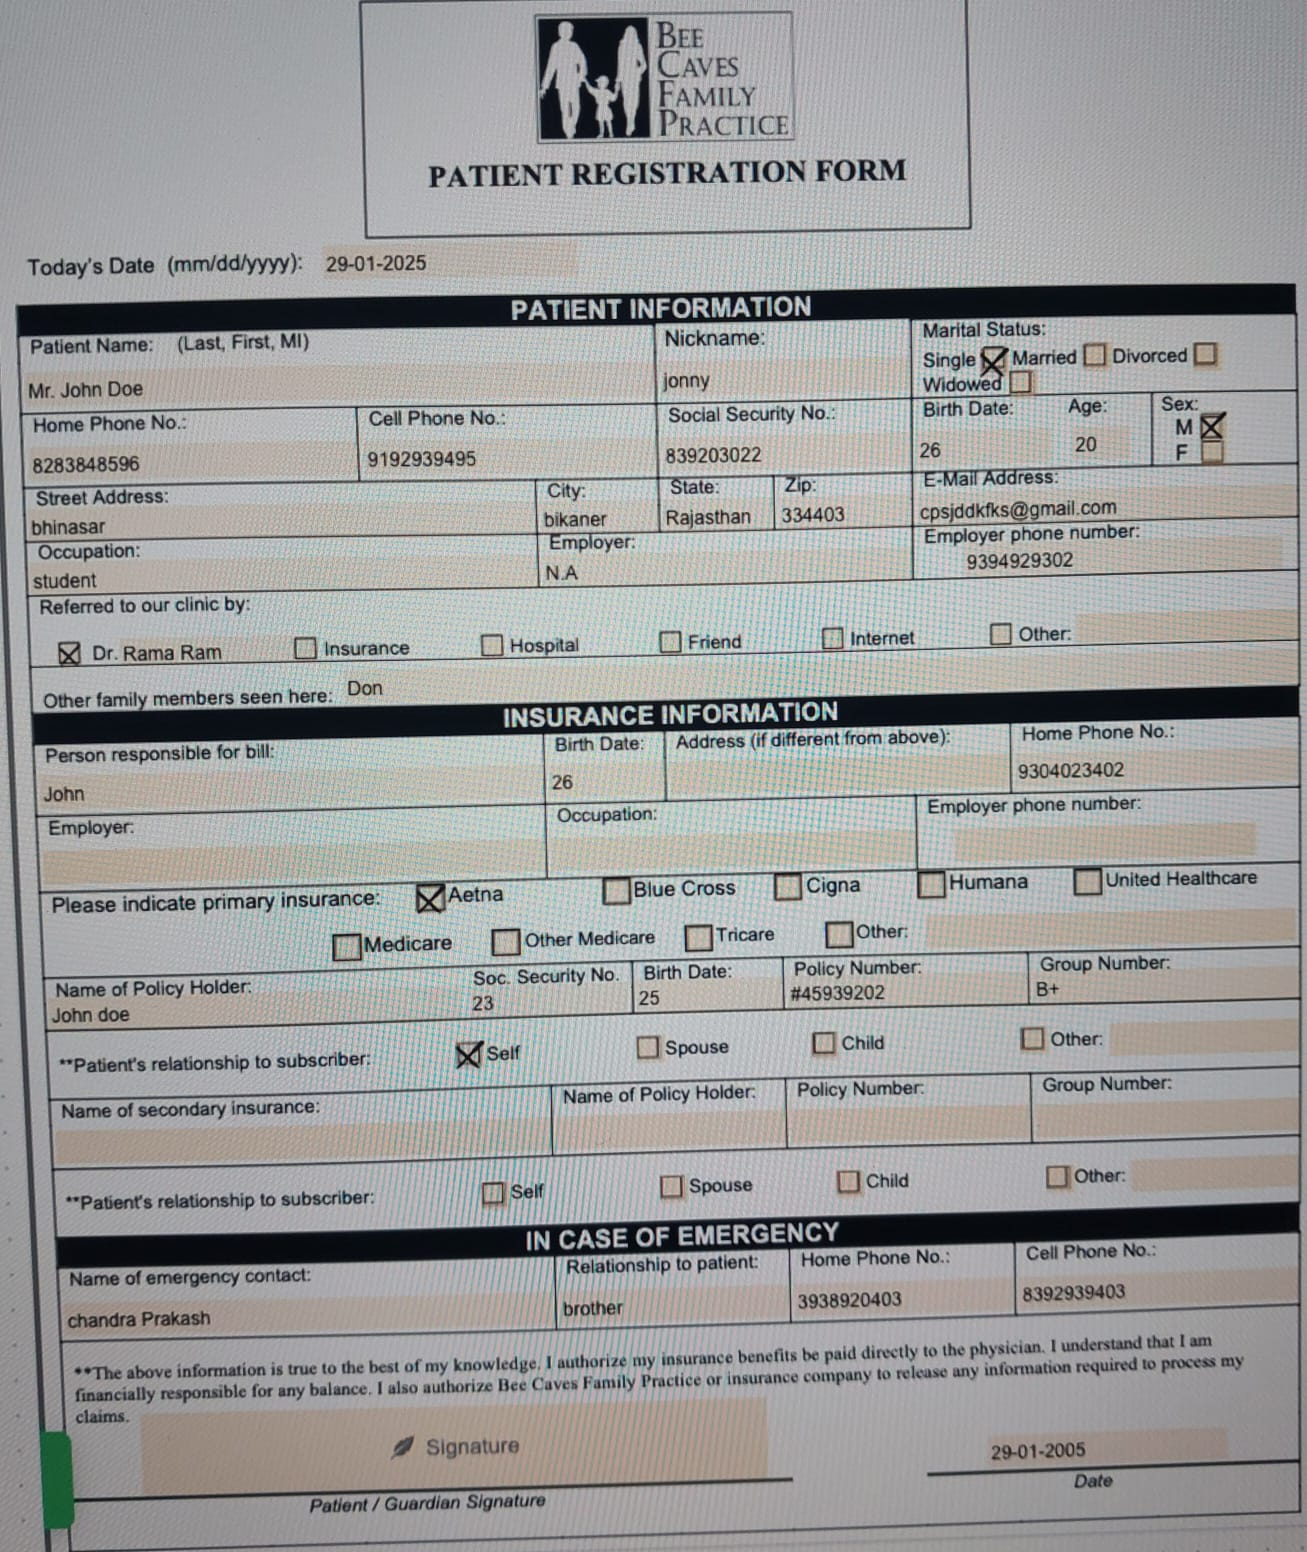


Extracting text...
[2025/01/30 05:38:20] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
def main():
    json_path = None
    temp_path = None

    try:
        print("Medical Form Processor")
        print("Upload medical form images to extract and structure data")

        # File upload
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded!")
            return

        temp_path = next(iter(uploaded))
        with open(temp_path, "wb") as f:
            f.write(uploaded[temp_path])

        # Display image
        display(Image.open(temp_path))

        # OCR Processing
        print("\nExtracting text...")
        try:
            sorted_text = sort_text_row_col(temp_path)
            ocr_text = " ".join([" ".join(row) for row in sorted_text])
            print(f"Extracted {len(ocr_text.split())} words")
            print(ocr_text)
        except Exception as e:
            print(f"OCR Error: {str(e)}")
            return

        if not ocr_text.strip():
            print("ERROR: No text extracted from image")
            return

        # LLM Processing
        print("\nStep 1: Data Structuring")
        try:
            agent1 = LlamaAgent(name="MedicalAgent", instructions=TOOLS_SYSTEM_PROMPT_STRUCTURE)
            print("Structuring data...")
            structured_text = agent1._query_ollama(ocr_text)
            print("\nData structured!")
            print("\nRaw Structured Output:")
            print(structured_text)
        except Exception as e:
            print(f"Structuring Error: {str(e)}")
            return

        # JSON Validation
        print("\nStep 2: JSON Structing")
        agent2 = LlamaAgent(name="JSONAGENT", instructions=TOOLS_SYSTEM_PROMPT_JSON)
        jsonData = agent2._query_ollama(structured_text)
        print(jsonData)
        print("\nStep 3: Validation & Export")
        json_data = validate_json(jsonData)

        if "error" in json_data:
            print("Invalid JSON Structure")
            print(f"Error Details: {json_data['error']}")
            print("\nProblematic JSON:")
            print(json_data.get("text", ""))
        else:
            print("Valid JSON Structure!")
            print("\nProcessed Data:")
            print(json.dumps(json_data, indent=2))

            # Save and download JSON
            json_path = "medical_data.json"
            with open(json_path, "w") as f:
                json.dump(json_data, f, indent=2)

            files.download(json_path)

    finally:
        # Cleanup
        if temp_path and os.path.exists(temp_path):
            os.remove(temp_path)
        if json_path and os.path.exists(json_path):
            os.remove(json_path)
if __name__ == "__main__":
    main()

Medical Form Processor
Upload medical form images to extract and structure data


Saving 2.jpeg to 2.jpeg


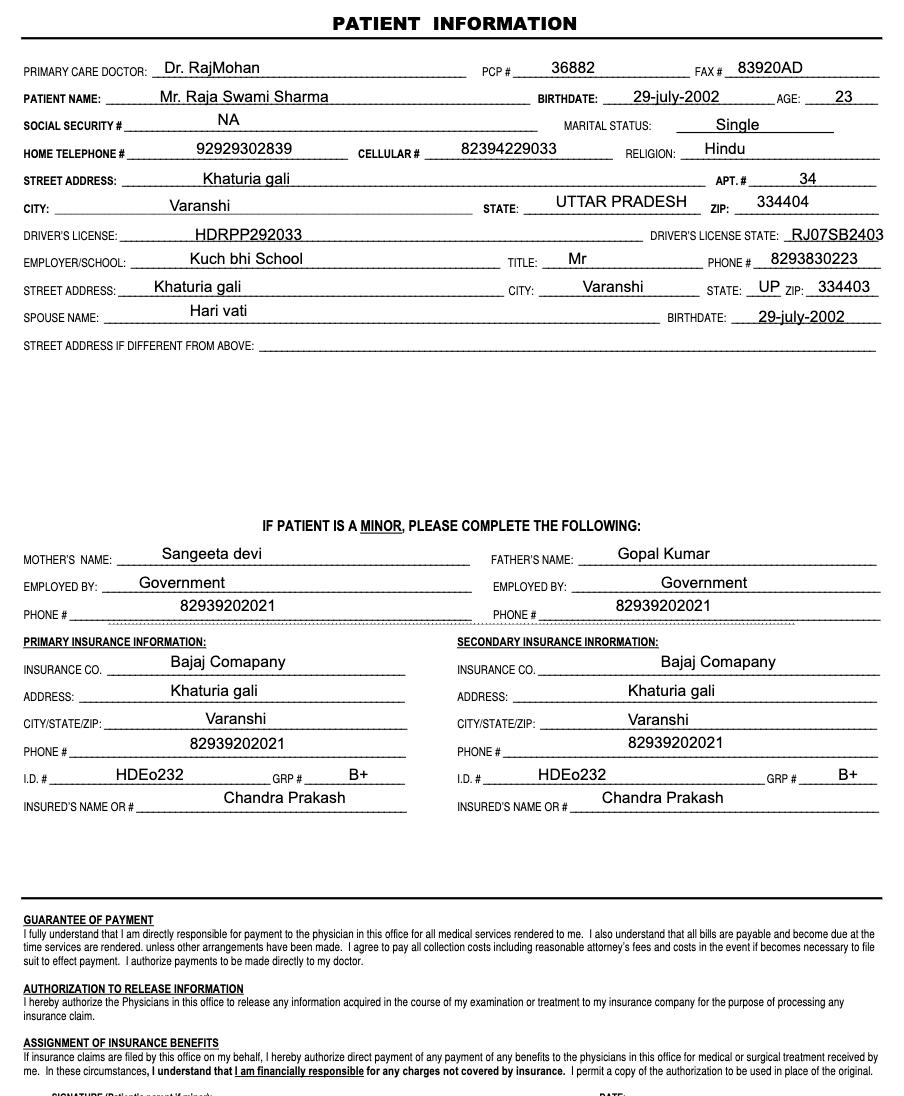


Extracting text...
[2025/01/30 05:43:25] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_t

In [14]:
def main():
    json_path = None
    temp_path = None

    try:
        print("Medical Form Processor")
        print("Upload medical form images to extract and structure data")

        # File upload
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded!")
            return

        temp_path = next(iter(uploaded))
        with open(temp_path, "wb") as f:
            f.write(uploaded[temp_path])

        # Display image
        display(Image.open(temp_path))

        # OCR Processing
        print("\nExtracting text...")
        try:
            sorted_text = sort_text_row_col(temp_path)
            ocr_text = " ".join([" ".join(row) for row in sorted_text])
            print(f"Extracted {len(ocr_text.split())} words")
            print(ocr_text)
        except Exception as e:
            print(f"OCR Error: {str(e)}")
            return

        if not ocr_text.strip():
            print("ERROR: No text extracted from image")
            return

        # LLM Processing
        print("\nStep 1: Data Structuring")
        try:
            agent1 = LlamaAgent(name="MedicalAgent", instructions=TOOLS_SYSTEM_PROMPT_STRUCTURE)
            print("Structuring data...")
            structured_text = agent1._query_ollama(ocr_text)
            print("\nData structured!")
            print("\nRaw Structured Output:")
            print(structured_text)
        except Exception as e:
            print(f"Structuring Error: {str(e)}")
            return

        # JSON Validation
        print("\nStep 2: JSON Structing")
        agent2 = LlamaAgent(name="JSONAGENT", instructions=TOOLS_SYSTEM_PROMPT_JSON)
        jsonData = agent2._query_ollama(structured_text)
        print(jsonData)
        print("\nStep 3: Validation & Export")
        json_data = validate_json(jsonData)

        if "error" in json_data:
            print("Invalid JSON Structure")
            print(f"Error Details: {json_data['error']}")
            print("\nProblematic JSON:")
            print(json_data.get("text", ""))
        else:
            print("Valid JSON Structure!")
            print("\nProcessed Data:")
            print(json.dumps(json_data, indent=2))

            # Save and download JSON
            json_path = "medical_data.json"
            with open(json_path, "w") as f:
                json.dump(json_data, f, indent=2)

            files.download(json_path)

    finally:
        # Cleanup
        if temp_path and os.path.exists(temp_path):
            os.remove(temp_path)
        if json_path and os.path.exists(json_path):
            os.remove(json_path)
if __name__ == "__main__":
    main()

Medical Form Processor
Upload medical form images to extract and structure data


Saving 4.png to 4.png


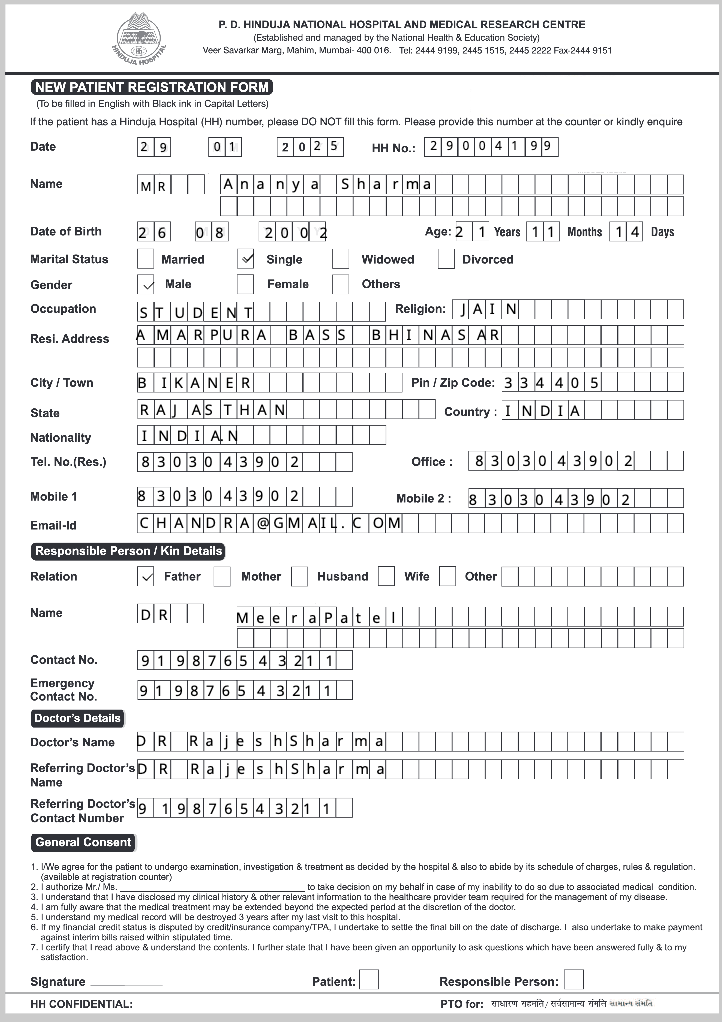


Extracting text...
[2025/01/30 05:44:55] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_t

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
def main():
    json_path = None
    temp_path = None

    try:
        print("Medical Form Processor")
        print("Upload medical form images to extract and structure data")

        # File upload
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded!")
            return

        temp_path = next(iter(uploaded))
        with open(temp_path, "wb") as f:
            f.write(uploaded[temp_path])

        # Display image
        display(Image.open(temp_path))

        # OCR Processing
        print("\nExtracting text...")
        try:
            sorted_text = sort_text_row_col(temp_path)
            ocr_text = " ".join([" ".join(row) for row in sorted_text])
            print(f"Extracted {len(ocr_text.split())} words")
            print(ocr_text)
        except Exception as e:
            print(f"OCR Error: {str(e)}")
            return

        if not ocr_text.strip():
            print("ERROR: No text extracted from image")
            return

        # LLM Processing
        print("\nStep 1: Data Structuring")
        try:
            agent1 = LlamaAgent(name="MedicalAgent", instructions=TOOLS_SYSTEM_PROMPT_STRUCTURE)
            print("Structuring data...")
            structured_text = agent1._query_ollama(ocr_text)
            print("\nData structured!")
            print("\nRaw Structured Output:")
            print(structured_text)
        except Exception as e:
            print(f"Structuring Error: {str(e)}")
            return

        # JSON Validation
        print("\nStep 2: JSON Structing")
        agent2 = LlamaAgent(name="JSONAGENT", instructions=TOOLS_SYSTEM_PROMPT_JSON)
        jsonData = agent2._query_ollama(structured_text)
        print(jsonData)
        print("\nStep 3: Validation & Export")
        json_data = validate_json(jsonData)

        if "error" in json_data:
            print("Invalid JSON Structure")
            print(f"Error Details: {json_data['error']}")
            print("\nProblematic JSON:")
            print(json_data.get("text", ""))
        else:
            print("Valid JSON Structure!")
            print("\nProcessed Data:")
            print(json.dumps(json_data, indent=2))

            # Save and download JSON
            json_path = "medical_data.json"
            with open(json_path, "w") as f:
                json.dump(json_data, f, indent=2)

            files.download(json_path)

    finally:
        # Cleanup
        if temp_path and os.path.exists(temp_path):
            os.remove(temp_path)
        if json_path and os.path.exists(json_path):
            os.remove(json_path)
if __name__ == "__main__":
    main()

Medical Form Processor
Upload medical form images to extract and structure data


Saving 5.png to 5.png


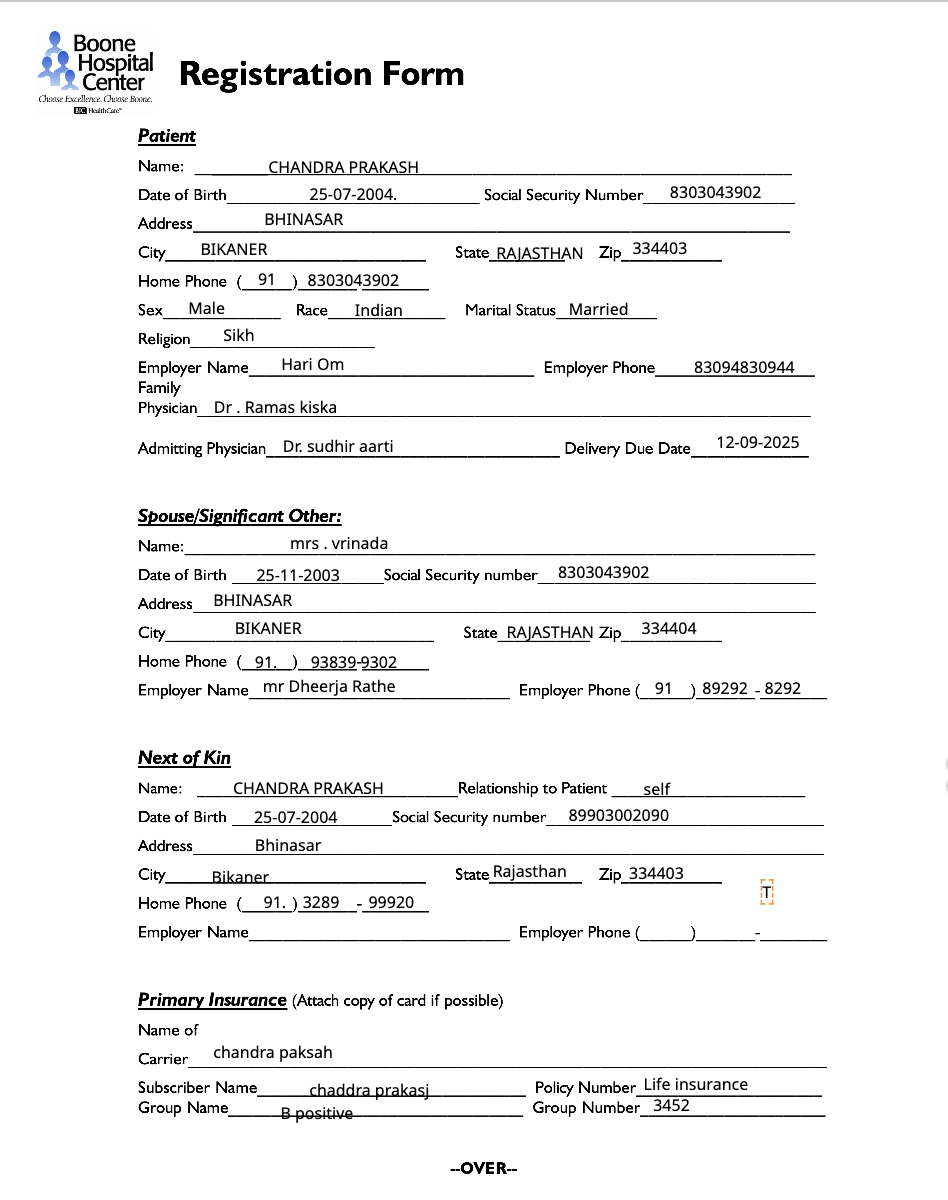


Extracting text...
[2025/01/30 05:46:30] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_t

In [16]:
def main():
    json_path = None
    temp_path = None

    try:
        print("Medical Form Processor")
        print("Upload medical form images to extract and structure data")

        # File upload
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded!")
            return

        temp_path = next(iter(uploaded))
        with open(temp_path, "wb") as f:
            f.write(uploaded[temp_path])

        # Display image
        display(Image.open(temp_path))

        # OCR Processing
        print("\nExtracting text...")
        try:
            sorted_text = sort_text_row_col(temp_path)
            ocr_text = " ".join([" ".join(row) for row in sorted_text])
            print(f"Extracted {len(ocr_text.split())} words")
            print(ocr_text)
        except Exception as e:
            print(f"OCR Error: {str(e)}")
            return

        if not ocr_text.strip():
            print("ERROR: No text extracted from image")
            return

        # LLM Processing
        print("\nStep 1: Data Structuring")
        try:
            agent1 = LlamaAgent(name="MedicalAgent", instructions=TOOLS_SYSTEM_PROMPT_STRUCTURE)
            print("Structuring data...")
            structured_text = agent1._query_ollama(ocr_text)
            print("\nData structured!")
            print("\nRaw Structured Output:")
            print(structured_text)
        except Exception as e:
            print(f"Structuring Error: {str(e)}")
            return

        # JSON Validation
        print("\nStep 2: JSON Structing")
        agent2 = LlamaAgent(name="JSONAGENT", instructions=TOOLS_SYSTEM_PROMPT_JSON)
        jsonData = agent2._query_ollama(structured_text)
        print(jsonData)
        print("\nStep 3: Validation & Export")
        json_data = validate_json(jsonData)

        if "error" in json_data:
            print("Invalid JSON Structure")
            print(f"Error Details: {json_data['error']}")
            print("\nProblematic JSON:")
            print(json_data.get("text", ""))
        else:
            print("Valid JSON Structure!")
            print("\nProcessed Data:")
            print(json.dumps(json_data, indent=2))

            # Save and download JSON
            json_path = "medical_data.json"
            with open(json_path, "w") as f:
                json.dump(json_data, f, indent=2)

            files.download(json_path)

    finally:
        # Cleanup
        if temp_path and os.path.exists(temp_path):
            os.remove(temp_path)
        if json_path and os.path.exists(json_path):
            os.remove(json_path)
if __name__ == "__main__":
    main()

Medical Form Processor
Upload medical form images to extract and structure data


Saving 6.jpeg to 6.jpeg


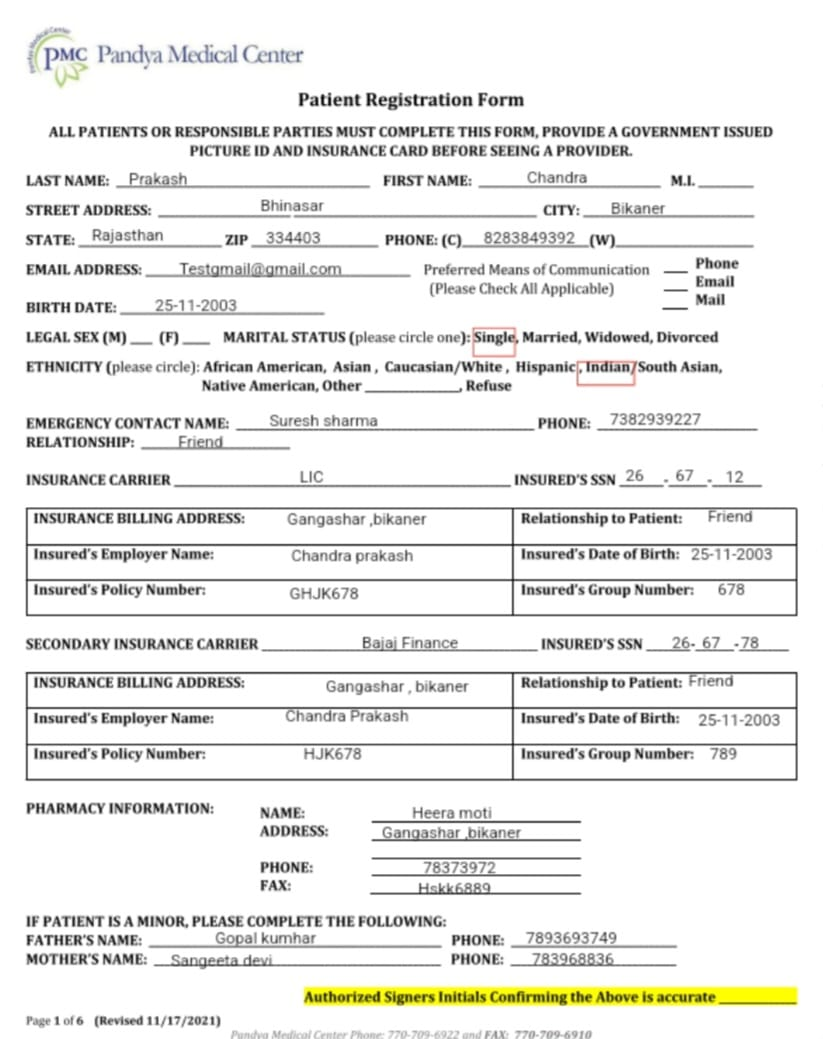


Extracting text...
[2025/01/30 05:53:09] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_t

In [17]:
def main():
    json_path = None
    temp_path = None

    try:
        print("Medical Form Processor")
        print("Upload medical form images to extract and structure data")

        # File upload
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded!")
            return

        temp_path = next(iter(uploaded))
        with open(temp_path, "wb") as f:
            f.write(uploaded[temp_path])

        # Display image
        display(Image.open(temp_path))

        # OCR Processing
        print("\nExtracting text...")
        try:
            sorted_text = sort_text_row_col(temp_path)
            ocr_text = " ".join([" ".join(row) for row in sorted_text])
            print(f"Extracted {len(ocr_text.split())} words")
            print(ocr_text)
        except Exception as e:
            print(f"OCR Error: {str(e)}")
            return

        if not ocr_text.strip():
            print("ERROR: No text extracted from image")
            return

        # LLM Processing
        print("\nStep 1: Data Structuring")
        try:
            agent1 = LlamaAgent(name="MedicalAgent", instructions=TOOLS_SYSTEM_PROMPT_STRUCTURE)
            print("Structuring data...")
            structured_text = agent1._query_ollama(ocr_text)
            print("\nData structured!")
            print("\nRaw Structured Output:")
            print(structured_text)
        except Exception as e:
            print(f"Structuring Error: {str(e)}")
            return

        # JSON Validation
        print("\nStep 2: JSON Structing")
        agent2 = LlamaAgent(name="JSONAGENT", instructions=TOOLS_SYSTEM_PROMPT_JSON)
        jsonData = agent2._query_ollama(structured_text)
        print(jsonData)
        print("\nStep 3: Validation & Export")
        json_data = validate_json(jsonData)

        if "error" in json_data:
            print("Invalid JSON Structure")
            print(f"Error Details: {json_data['error']}")
            print("\nProblematic JSON:")
            print(json_data.get("text", ""))
        else:
            print("Valid JSON Structure!")
            print("\nProcessed Data:")
            print(json.dumps(json_data, indent=2))

            # Save and download JSON
            json_path = "medical_data.json"
            with open(json_path, "w") as f:
                json.dump(json_data, f, indent=2)

            files.download(json_path)

    finally:
        # Cleanup
        if temp_path and os.path.exists(temp_path):
            os.remove(temp_path)
        if json_path and os.path.exists(json_path):
            os.remove(json_path)
if __name__ == "__main__":
    main()

Medical Form Processor
Upload medical form images to extract and structure data


Saving form3.1.jpeg to form3.1.jpeg


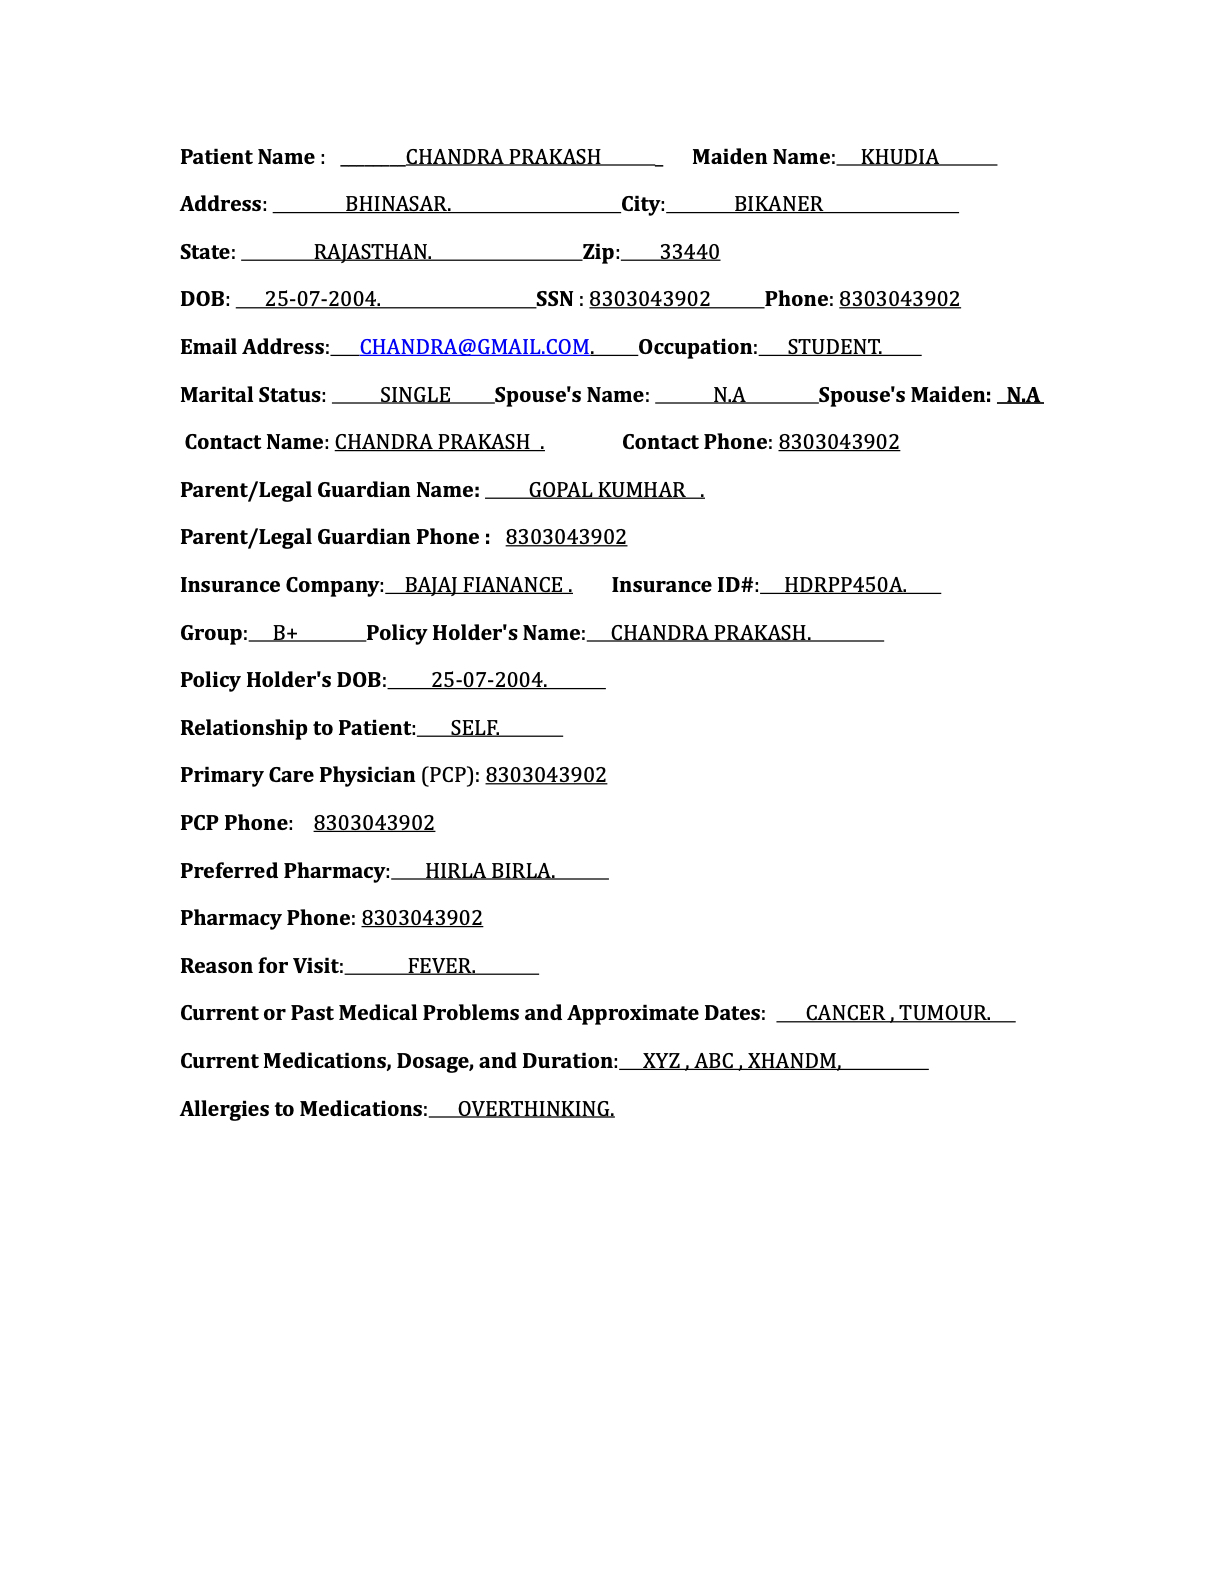


Extracting text...
[2025/01/30 05:55:36] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_t

In [18]:
def main():
    json_path = None
    temp_path = None

    try:
        print("Medical Form Processor")
        print("Upload medical form images to extract and structure data")

        # File upload
        uploaded = files.upload()
        if not uploaded:
            print("No file uploaded!")
            return

        temp_path = next(iter(uploaded))
        with open(temp_path, "wb") as f:
            f.write(uploaded[temp_path])

        # Display image
        display(Image.open(temp_path))

        # OCR Processing
        print("\nExtracting text...")
        try:
            sorted_text = sort_text_row_col(temp_path)
            ocr_text = " ".join([" ".join(row) for row in sorted_text])
            print(f"Extracted {len(ocr_text.split())} words")
            print(ocr_text)
        except Exception as e:
            print(f"OCR Error: {str(e)}")
            return

        if not ocr_text.strip():
            print("ERROR: No text extracted from image")
            return

        # LLM Processing
        print("\nStep 1: Data Structuring")
        try:
            agent1 = LlamaAgent(name="MedicalAgent", instructions=TOOLS_SYSTEM_PROMPT_STRUCTURE)
            print("Structuring data...")
            structured_text = agent1._query_ollama(ocr_text)
            print("\nData structured!")
            print("\nRaw Structured Output:")
            print(structured_text)
        except Exception as e:
            print(f"Structuring Error: {str(e)}")
            return

        # JSON Validation
        print("\nStep 2: JSON Structing")
        agent2 = LlamaAgent(name="JSONAGENT", instructions=TOOLS_SYSTEM_PROMPT_JSON)
        jsonData = agent2._query_ollama(structured_text)
        print(jsonData)
        print("\nStep 3: Validation & Export")
        json_data = validate_json(jsonData)

        if "error" in json_data:
            print("Invalid JSON Structure")
            print(f"Error Details: {json_data['error']}")
            print("\nProblematic JSON:")
            print(json_data.get("text", ""))
        else:
            print("Valid JSON Structure!")
            print("\nProcessed Data:")
            print(json.dumps(json_data, indent=2))

            # Save and download JSON
            json_path = "medical_data.json"
            with open(json_path, "w") as f:
                json.dump(json_data, f, indent=2)

            files.download(json_path)

    finally:
        # Cleanup
        if temp_path and os.path.exists(temp_path):
            os.remove(temp_path)
        if json_path and os.path.exists(json_path):
            os.remove(json_path)
if __name__ == "__main__":
    main()